# GLGENN on Colored Fashion-MNIST

This notebook builds a full training pipeline for a colored Fashion-MNIST dataset and trains a GLGENN model based on Clifford geometric algebra. The structure mirrors the CGENN tutorial but adapts the data embedding and model for images.


## Setup


In [2]:
import os
import random
from dataclasses import dataclass

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms

from algebra.cliffordalgebraex import CliffordAlgebraQT
from layers.qtgp import QTGeometricProduct
from layers.qtlinear import QTLinear




ModuleNotFoundError: No module named 'algebra'

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cpu


## Configuration


In [3]:
@dataclass
class Config:
    data_root: str = "./data"
    img_size: int = 14
    batch_size: int = 128
    num_workers: int = 0
    num_epochs: int = 12
    lr: float = 3e-4
    weight_decay: float = 1e-4
    hidden_features: int = 96
    num_classes: int = 10
    train_split: float = 0.9
    palette_seed: int = 123

cfg = Config()
cfg



Config(data_root='./data', img_size=14, batch_size=128, num_workers=0, num_epochs=12, lr=0.0003, weight_decay=0.0001, hidden_features=96, num_classes=10, train_split=0.9, palette_seed=123)

## Colored Fashion-MNIST


In [4]:
def make_palette():
    # Distinct, moderately saturated colors in RGB
    return torch.tensor(
        [
            [0.90, 0.25, 0.25],
            [0.25, 0.75, 0.25],
            [0.25, 0.45, 0.90],
            [0.90, 0.65, 0.20],
            [0.65, 0.25, 0.90],
            [0.20, 0.85, 0.75],
            [0.85, 0.20, 0.55],
            [0.55, 0.55, 0.20],
        ],
        dtype=torch.float32,
    )


class ColoredFashionMNIST(Dataset):
    def __init__(self, root, train, palette, seed=0, transform=None, download=True):
        self.base = datasets.FashionMNIST(
            root,
            train=train,
            download=download,
            transform=transforms.ToTensor(),
        )
        self.palette = palette
        self.seed = seed
        self.transform = transform

    def _color_for_index(self, idx):
        # Deterministic color per sample to keep the dataset stable across epochs
        g = torch.Generator().manual_seed(self.seed + idx)
        color_idx = torch.randint(len(self.palette), (1,), generator=g).item()
        return self.palette[color_idx]

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, label = self.base[idx]
        color = self._color_for_index(idx)
        colored = img * color[:, None, None]
        if self.transform is not None:
            colored = self.transform(colored)
        return colored, label


def compute_channel_stats(loader, max_batches=200):
    total_sum = torch.zeros(3)
    total_sum_sq = torch.zeros(3)
    total_count = 0

    for i, (x, _) in enumerate(loader):
        b, c, h, w = x.shape
        total_sum += x.sum(dim=(0, 2, 3))
        total_sum_sq += (x ** 2).sum(dim=(0, 2, 3))
        total_count += b * h * w
        if max_batches is not None and i + 1 >= max_batches:
            break

    mean = total_sum / total_count
    std = (total_sum_sq / total_count - mean ** 2).sqrt()
    return mean, std



In [5]:
palette = make_palette()
resize = transforms.Resize((cfg.img_size, cfg.img_size), antialias=True)

raw_train = ColoredFashionMNIST(
    cfg.data_root,
    train=True,
    palette=palette,
    seed=cfg.palette_seed,
    transform=resize,
    download=True,
)
raw_loader = DataLoader(raw_train, batch_size=cfg.batch_size, shuffle=False)

mean, std = compute_channel_stats(raw_loader, max_batches=200)
print("Approx mean:", mean)
print("Approx std:", std)

train_transform = transforms.Compose([
    resize,
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    resize,
    transforms.Normalize(mean, std),
])

full_train = ColoredFashionMNIST(
    cfg.data_root,
    train=True,
    palette=palette,
    seed=cfg.palette_seed,
    transform=train_transform,
    download=True,
)

test_set = ColoredFashionMNIST(
    cfg.data_root,
    train=False,
    palette=palette,
    seed=cfg.palette_seed,
    transform=test_transform,
    download=True,
)

train_size = int(cfg.train_split * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

train_loader = DataLoader(
    train_set,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=torch.cuda.is_available(),
)
val_loader = DataLoader(
    val_set,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=torch.cuda.is_available(),
)
test_loader = DataLoader(
    test_set,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=torch.cuda.is_available(),
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))



100%|██████████| 26.4M/26.4M [00:10<00:00, 2.47MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:03<00:00, 1.25MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.24MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Approx mean: tensor([0.1627, 0.1426, 0.1435])
Approx std: tensor([0.2153, 0.1848, 0.2011])
Train batches: 422
Val batches: 47
Test batches: 79


## Sample Visualization


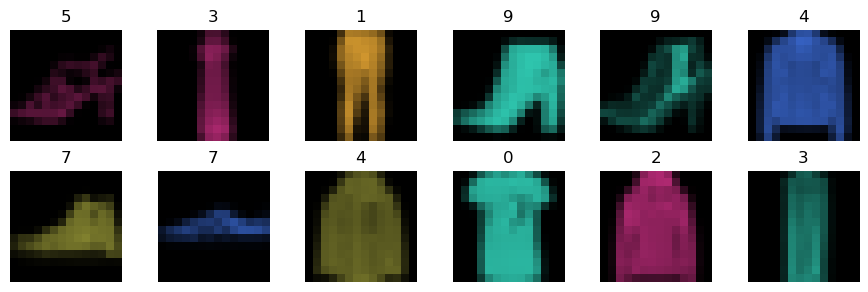

In [6]:
import matplotlib.pyplot as plt

x, y = next(iter(train_loader))
fig, axes = plt.subplots(2, 6, figsize=(9, 3))
for i, ax in enumerate(axes.flat):
    img = x[i].permute(1, 2, 0)
    img = (img * std + mean).clamp(0, 1)
    ax.imshow(img)
    ax.set_title(int(y[i]))
    ax.axis("off")
plt.tight_layout()



## GLGENN Model


In [7]:
class GLGBlock(nn.Module):
    def __init__(self, algebra, in_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            QTLinear(algebra, in_features, out_features),
            QTGeometricProduct(algebra, out_features),
        )

    def forward(self, x):
        return self.layers(x)


class GLGClassifier(nn.Module):
    def __init__(self, img_size, hidden_features, num_classes):
        super().__init__()
        self.algebra = CliffordAlgebraQT((1.0, 1.0, 1.0))
        self.num_tokens = img_size * img_size

        self.block1 = GLGBlock(self.algebra, self.num_tokens, hidden_features)
        self.block2 = GLGBlock(self.algebra, hidden_features, hidden_features)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_features, num_classes),
        )

    def forward(self, x):
        # x: [B, 3, H, W]
        b, c, h, w = x.shape
        x = x.permute(0, 2, 3, 1).reshape(b, h * w, c)

        mv = self.algebra.embed_grade(x, 1)
        h = self.block1(mv)
        h = torch.tanh(h)
        h = self.block2(h)
        h = torch.tanh(h)

        # Invariant scalar part
        scalars = h[..., 0]
        return self.classifier(scalars)



## Training Utilities


In [8]:
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()


def run_epoch(model, loader, optimizer=None, clip_grad=1.0):
    train_mode = optimizer is not None
    model.train(train_mode)

    total_loss = 0.0
    total_acc = 0.0
    total_count = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = nn.CrossEntropyLoss()(logits, y)

        if train_mode:
            optimizer.zero_grad()
            loss.backward()
            if clip_grad is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_acc += accuracy_from_logits(logits, y) * batch_size
        total_count += batch_size

    return total_loss / total_count, total_acc / total_count



## Train the GLGENN


In [9]:
model = GLGClassifier(
    img_size=cfg.img_size,
    hidden_features=cfg.hidden_features,
    num_classes=cfg.num_classes,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.num_epochs)

best_val_acc = 0.0
for epoch in range(1, cfg.num_epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f}"
    )

print("Best val acc:", best_val_acc)



Epoch 01 | train loss 0.8597 acc 0.7175 | val loss 0.5345 acc 0.8087
Epoch 02 | train loss 0.4793 acc 0.8264 | val loss 0.4566 acc 0.8342
Epoch 03 | train loss 0.4217 acc 0.8462 | val loss 0.4309 acc 0.8438
Epoch 04 | train loss 0.3926 acc 0.8577 | val loss 0.3946 acc 0.8533
Epoch 05 | train loss 0.3705 acc 0.8664 | val loss 0.3827 acc 0.8640
Epoch 06 | train loss 0.3531 acc 0.8715 | val loss 0.3722 acc 0.8635
Epoch 07 | train loss 0.3408 acc 0.8768 | val loss 0.3599 acc 0.8682
Epoch 08 | train loss 0.3308 acc 0.8802 | val loss 0.3580 acc 0.8688
Epoch 09 | train loss 0.3223 acc 0.8833 | val loss 0.3571 acc 0.8707
Epoch 10 | train loss 0.3166 acc 0.8857 | val loss 0.3502 acc 0.8708
Epoch 11 | train loss 0.3118 acc 0.8870 | val loss 0.3494 acc 0.8727
Epoch 12 | train loss 0.3090 acc 0.8890 | val loss 0.3493 acc 0.8737
Best val acc: 0.8736666663487752


## Test Evaluation


In [10]:
test_loss, test_acc = run_epoch(model, test_loader, optimizer=None)
print(f"Test loss {test_loss:.4f} | test acc {test_acc:.4f}")



Test loss 0.3720 | test acc 0.8672
